In [19]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EOS: Distribution Grid Management Analysis

This notebook takes you through the analysis of EnergyOS for the case of distribution grid management. It compares current state of disconnected, independent grids to an EnergyOS-connected world in which a DSO is able to communicate limits to its building.

A building sends its DSO its day-ahead schedule for its operation, including it's planned imports and exports to the grid. With this information, a DDSO is able to warn its flexible buildings of an incoming grid limit and the building apps can re-optimize their schedules with these conflicts in mind. We use the buildings as the optimally-operating households of the household load scheduling case study.

We compare the outcome of these situations, in terms of the amount of lost energy and hypothesize about the impacts of only finding out in real time.

In [20]:
load = pd.read_csv('input/hh_load_muc_2013-06-10.csv', index_col=0)
pv = pd.read_csv('input/solar_muc_2013-06-10.csv', index_col=0)
input_data = pd.DataFrame()
input_data['load (kW)'] = load['kW']
input_data['solar_power (kW)'] = pv['kW']

## Running OpenTUMFlex simulations

We can then use these forecasts directly as the input data for OpenTUMFlex, in order to get optimal charge schedules.

We will need to replace the existing input data with our desired curves, run the OpenTUMFlex simulation, and save the schedules as output.

The code to read and write the CSV was taken from the `read_data` function of [init_ems.py](https://github.com/tum-ewk/OpenTUMFlex/blob/master/opentumflex/configuration/init_ems.py) from the OpenTUMFlex source code.

In [21]:
def read_OpenTUMFlex_input(input_file='input/input_data.csv'):
    csv_data = pd.read_csv(input_file, sep=';', index_col=0)
    prop = csv_data.iloc[:, 0:2].dropna(how='all')
    ts = csv_data.iloc[:, 2:].dropna(how='all')
    return prop, ts

def write_OpenTUMFlex_input(prop, ts, output_file='output/eos_input_data.csv'):
    pd.concat([prop, ts], sort=False).to_csv(output_file, sep=';')

The original forecast input looks like this:

In [22]:
prop, ts = read_OpenTUMFlex_input(input_file='input/input_data.csv')
ts.head()

temperature  solar_power  load_heat  load_elec  ele_price_in  gas_price  \
0          0.0          0.0   0.001200   0.000533      0.281831   0.074988   
1          0.0          0.0   0.017007   0.516305      0.283655   0.072956   
2          0.0          0.0   0.001200   0.516305      0.285463   0.074012   
3          0.0          0.0   0.055172   0.516305      0.287247   0.070524   
4          0.0          0.0   2.205382   0.726054      0.289000   0.076582   

   ele_price_out  ev_aval  
0           0.11      1.0  
1           0.11      1.0  
2           0.11      1.0  
3           0.11      1.0  
4           0.11      1.0

To make it easier to run these EOS OpenTUMFlex cases, we made a utility script, and a function here that outputs instructions on how to run the command. It utilizes the timeseries above to run certain cases depending on your given params. We first want to run the EV cases, since the Battery will optimize with the EV's additional load in mind. We can also pass in `grid_limits` to be take into account in the optimization.

**Function parameters for `prepare_EOS_sim`**

device: 'bat' or 'ev' \
extra_ev_load_file: Path to file for the ev load to add for the combined case. \
output_schedule_file: Path to the file you want the OpenTUMFlex output to go to. \
grid_limits: A schedule of DSO-imposed limits for the building.
 
**Note:** You will need the absolute path to the file, if the relative one is incorrect.

In [23]:
def prepare_EOS_sim(device, extra_ev_load_file, output_schedule_file, grid_limits=None):
    assert device == 'bat' or device == 'ev'
    if device == 'ev':
        assert extra_ev_load_file == None

    input_data_file = 'input/input_data.csv'
    output_data_file = 'output/eos_input_data.csv'
    

    # Put forecasts into input file
    prop, ts = read_OpenTUMFlex_input(input_data_file)
    ts['solar_power'][0:len(pv)] = input_data['solar_power (kW)']
    ts['load_elec'][0:len(load)] = input_data['load (kW)']
    if device == 'bat':
        assert extra_ev_load_file != None
        ev_load = pd.read_csv(extra_ev_load_file, index_col=0)
        ts['load_elec'][0:len(load)] = input_data['load (kW)'] + ev_load['EV_power']
    ts['ev_aval'][0:len(pv)] = pd.Series([1.0]*len(pv)) # Make ev always available
    ts['grid_limits'] = pd.Series([50*5000]*len(ts))
    if grid_limits is not None:
        ts['grid_limits'][0:len(pv)] = grid_limits
    write_OpenTUMFlex_input(prop, ts, output_data_file)

    # Output commands
    command = 'python eos_sim.py -m {name} -i {output_data_file} -o {output_schedule_file}'.format(
        output_data_file=output_data_file, name=device, output_schedule_file=output_schedule_file)
    info = (
        'The forecasts have been added to {output_data_file}. You can use it as follows to run OpenTUMFlex:\n\n'
        '{command}\n'
    ).format(output_data_file=output_data_file, command=command)
    return command, info

Now we setup the cases we are actually interested in, and optionally run the simulator from here. To run the simulator, you need to provide your conda environment name that has OpenTUMFlex as `conda_env`, and set the `run` variable to True.

In [24]:
# Need to do ev cases before Battery cases because Battery depends on EV.
no_limit = pd.Series([50*5000]*96)
constant_limit = pd.Series([2]*96)
sims = [
    ('ev', None, 'output/eos_ev_none.csv', no_limit),
    ('bat', 'output/eos_ev_none.csv', 'output/eos_bat_none.csv', no_limit),
    ('ev', None, 'output/eos_ev_constant.csv', constant_limit),
    ('bat', 'output/eos_ev_constant.csv', 'output/eos_bat_constant.csv', constant_limit),
]

run = True
conda_env = 'flex-scheduler'
for device, extra_ev_load_file, output, limits in sims:
    cmd, info = prepare_EOS_sim(device, extra_ev_load_file, output, limits)
    if run:
        final_cmd = 'conda run -n {env} {cmd}'.format(env=conda_env, cmd=cmd)
        subprocess.run(final_cmd, shell=True)
    else:
        print(info)

/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_neg][i] = ev_flex_temp[p_neg].iat[i] * t_neg_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_pos][i] = ev_flex_temp[p_pos].iat[i] * t_pos_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.119021' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 0] = dat1.iloc[i, 2]  - dat1.iloc[i, 1]
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.119021' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 1] = -1*nflex_P
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.08926575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 3] = Bat_flex.iloc

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_neg][i] = ev_flex_temp[p_neg].iat[i] * t_neg_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_pos][i] = ev_flex_temp[p_pos].iat[i] * t_pos_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

This model is feasible and there is an optimal

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.139794' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 0] = dat1.iloc[i, 2]  - dat1.iloc[i, 1]
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.139794' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 1] = -1*nflex_P
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.1048455' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 3] = Bat_flex.iloc[

## Moving the data to EnergyOS

Now that we have prepared all the data, we want to move all the relevant data for EnergyOS to specific files.

Only do this if you want to override the current data. You will need to change override to True.

We move over the load and pv curves, grid limits, import and export prices, ev charge schedules, and battery charge and discharge schedules.

In [25]:
input_data['grid_limits_none (kW)'] = no_limit
input_data['grid_limits_constant (kW)'] = constant_limit

prop, ts = read_OpenTUMFlex_input(input_file='output/eos_input_data.csv')
imp = list(ts['ele_price_in'][0:len(input_data)])
exp = list(ts['ele_price_out'][0:len(input_data)])
input_data['import_price (€/kWh)'] = pd.Series(imp)
input_data['export_price (€/kWh)'] = exp

charge = 'EV_power'
ev_none = pd.read_csv('output/eos_ev_none.csv', index_col=0)
ev_constant = pd.read_csv('output/eos_ev_constant.csv', index_col=0)
input_data['ev_charge_none (kW)'] = ev_none[charge]
input_data['ev_charge_constant (kW)'] = ev_constant[charge]

charge = 'bat_input_power'
discharge = 'bat_output_power'
bat_none = pd.read_csv('output/eos_bat_none.csv', index_col=0)
bat_constant = pd.read_csv('output/eos_bat_constant.csv', index_col=0)
input_data['bat_charge_none (kW)'] = bat_none[charge]
input_data['bat_discharge_none (kW)'] = bat_none[discharge]
input_data['bat_charge_constant (kW)'] = bat_constant[charge]
input_data['bat_discharge_constant (kW)'] = bat_constant[discharge]

input_data

load (kW)  solar_power (kW)  grid_limits_none (kW)  \
0    0.119021               0.0                 250000   
1    0.123648               0.0                 250000   
2    0.136930               0.0                 250000   
3    0.139794               0.0                 250000   
4    0.146937               0.0                 250000   
..        ...               ...                    ...   
91   0.160502               0.0                 250000   
92   0.162659               0.0                 250000   
93   0.129153               0.0                 250000   
94   0.119229               0.0                 250000   
95   0.134386               0.0                 250000   

    grid_limits_constant (kW)  import_price (€/kWh)  export_price (€/kWh)  \
0                           2              0.281831                  0.11   
1                           2              0.283655                  0.11   
2                           2              0.285463                  0.11   
3                           2              0.287247                  0.11   
4                           2              0.289000                  0.11   
..                        ...                   ...                   ...   
91                          2              0.272753                  0.11   
92                          2              0.274537                  0.11   
93                          2              0.276345                  0.11   
94                          2              0.278169                  0.11   
95                          2              0.299743                  0.11   

    ev_charge_none (kW)  ev_charge_constant (kW)  bat_charge_none (kW)  \
0                   0.0                      0.0                   0.0   
1                   0.0                      0.0                   0.0   
2                   0.0                      0.0                   0.0   
3                   0.0                      0.0                   0.0   
4                   0.0                      0.0                   0.0   
..                  ...                      ...                   ...   
91                  0.0                      0.0                   0.0   
92                  0.0                      0.0                   0.0   
93                  0.0                      0.0                   0.0   
94                  0.0                      0.0                   0.0   
95                  0.0                      0.0                   0.0   

    bat_discharge_none (kW)  bat_charge_constant (kW)  \
0                  0.119021                       0.0   
1                  0.123648                       0.0   
2                  0.136930                       0.0   
3                  0.139794                       0.0   
4                  0.146937                       0.0   
..                      ...                       ...   
91                 0.000000                       0.0   
92                 0.000000                       0.0   
93                 0.000000                       0.0   
94                 0.000000                       0.0   
95                 0.134386                       0.0   

    bat_discharge_constant (kW)  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.139794  
4                      0.146937  
..                          ...  
91                     0.000000  
92                     0.000000  
93                     0.000000  
94                     0.000000  
95                     0.134386  

[96 rows x 12 columns]

In [26]:
OVERRIDE = True
base_dir = 'data/' if OVERRIDE else 'test_data/'
input_data.to_csv(base_dir + 'eos_grid_analysis.csv')

## Analysis

Now we can analyze the different scenarios. We do this in a separate notebook.

The main data should now be in if you set `OVERRIDE` to True.

```
data/eos_grid_analysis.csv
```

In [29]:
eos_data = pd.read_csv('data/eos_grid_analysis.csv', index_col=0)
eos_data

load (kW)  solar_power (kW)  grid_limits_none (kW)  \
0    0.119021               0.0                 250000   
1    0.123648               0.0                 250000   
2    0.136930               0.0                 250000   
3    0.139794               0.0                 250000   
4    0.146937               0.0                 250000   
..        ...               ...                    ...   
91   0.160502               0.0                 250000   
92   0.162659               0.0                 250000   
93   0.129153               0.0                 250000   
94   0.119229               0.0                 250000   
95   0.134386               0.0                 250000   

    grid_limits_constant (kW)  import_price (€/kWh)  export_price (€/kWh)  \
0                           2              0.281831                  0.11   
1                           2              0.283655                  0.11   
2                           2              0.285463                  0.11   
3                           2              0.287247                  0.11   
4                           2              0.289000                  0.11   
..                        ...                   ...                   ...   
91                          2              0.272753                  0.11   
92                          2              0.274537                  0.11   
93                          2              0.276345                  0.11   
94                          2              0.278169                  0.11   
95                          2              0.299743                  0.11   

    ev_charge_none (kW)  ev_charge_constant (kW)  bat_charge_none (kW)  \
0                   0.0                      0.0                   0.0   
1                   0.0                      0.0                   0.0   
2                   0.0                      0.0                   0.0   
3                   0.0                      0.0                   0.0   
4                   0.0                      0.0                   0.0   
..                  ...                      ...                   ...   
91                  0.0                      0.0                   0.0   
92                  0.0                      0.0                   0.0   
93                  0.0                      0.0                   0.0   
94                  0.0                      0.0                   0.0   
95                  0.0                      0.0                   0.0   

    bat_discharge_none (kW)  bat_charge_constant (kW)  \
0                  0.119021                       0.0   
1                  0.123648                       0.0   
2                  0.136930                       0.0   
3                  0.139794                       0.0   
4                  0.146937                       0.0   
..                      ...                       ...   
91                 0.000000                       0.0   
92                 0.000000                       0.0   
93                 0.000000                       0.0   
94                 0.000000                       0.0   
95                 0.134386                       0.0   

    bat_discharge_constant (kW)  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.139794  
4                      0.146937  
..                          ...  
91                     0.000000  
92                     0.000000  
93                     0.000000  
94                     0.000000  
95                     0.134386  

[96 rows x 12 columns]

## Cost Analysis

We essentially use the same cost analysis as in the Household Load Scheduling example. It uses the total produced power (`PV_total_real + bat_discharge`), and the total consumed power (`load_real + bat_charge + ev_charge`) to determine the grid imports and exports. It then takes these imports and exports and returns the cost of using energy for that day.

One tweak is that we now also take into account grid limits. If limits is not None, we clip the imported energy to the corresponding limit for that time, such that there is an upper bound on the amount of imported energy. If fix is True, we then implement a naive fixing scheme that shifts any excess demand to the next available time slot.

We use the following function:

In [30]:
import_price = eos_data['import_price (€/kWh)']
export_price = eos_data['export_price (€/kWh)']
def calculate_cost(bat_discharge, bat_charge, ev_charge, limits=None, fix=False):
    '''
    Calculates the total cost and also returns the imported and exported amounts of energy.

    Returns: (price, imported_series, exported_series)
    '''
    def fix_import_schedule(schedule):
        carryover = 0
        end = len(schedule)-1
        new_schedule = list(schedule)
        for index, val in schedule.items():
            new_val = new_schedule[index]
            limit = limits[index]
            if index == end:
                pass
            elif new_val > limit:
                diff = new_val - limit
                new_val = limit
                new_schedule[index+1]+=diff
            new_schedule[index] = new_val
        return pd.Series(new_schedule)
        
    produced = eos_data['solar_power (kW)'] + bat_discharge
    consumed = eos_data['load (kW)'] + bat_charge + ev_charge

    # Make exported and imported series
    exported = (produced - consumed).clip(lower=0)
    exported.name = 'exported_total'
    imported = (consumed - produced).clip(lower=0)
    imported.name = 'imported_total_normal'
    if limits is not None:
        imported_limit = imported.clip(upper=limits)
        if fix and np.sum(imported) - np.sum(imported_limit) > 0.000000000001:
            imported_limit = fix_import_schedule(imported).clip(upper=limits)
    else:
        imported_limit = imported
    imported_limit.name = 'imported_total_limit'
        

    # Each power measurement is valid for 1/4 of an hour.
    # So to get kWh, multiply by 1/4.
    return np.sum(imported_limit*(1/4)*import_price - exported*(1/4)*export_price), imported, exported, imported_limit

## Scenarios

We can now analyze all interesting scenarios, and compare their prices and grid interactions.

In [31]:
cases = {}

### 1. No limit

This is the reference case and is what happens when there are no limits to the import of energy from the grid. The building is simply free to optimize how it pleases.

Cost: 2.8584779646429856
Total Energy Needed: 11.304057492917035
Energy Loss due to limits: 0.0


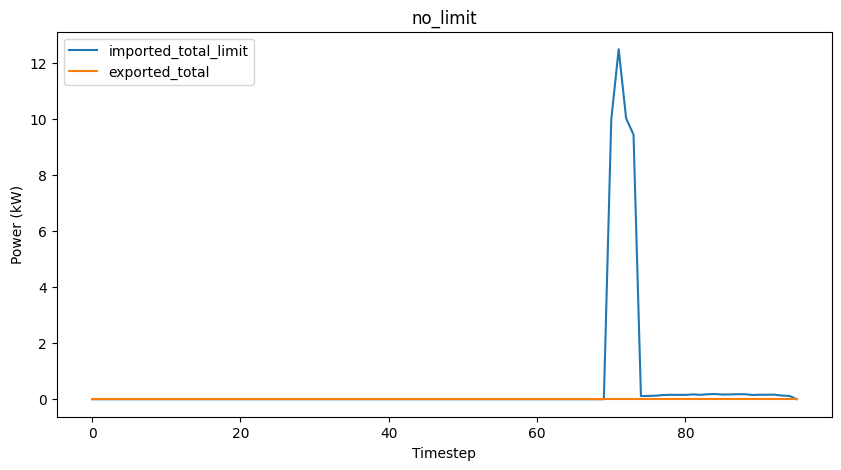

In [32]:
case_name = 'no_limit'
bat_discharge = eos_data['bat_discharge_none (kW)']
bat_charge = eos_data['bat_charge_none (kW)']
ev_charge = eos_data['ev_charge_none (kW)']
limits = eos_data['grid_limits_none (kW)']

cost, imported, exported, imported_limit = calculate_cost(bat_discharge=bat_discharge,
                                                          bat_charge=bat_charge,
                                                          ev_charge=ev_charge,
                                                          limits=limits)

cases[case_name] = (cost, imported, exported, imported_limit, bat_discharge, bat_charge, ev_charge)

imported_limit.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
if case_name != 'no_limit':
    limits.name = 'grid_limit'
    limits.plot(figsize=(10,5), linestyle = 'dotted')
plt.legend(loc="upper left")
plt.title(case_name)
plt.xlabel('Timestep')
plt.ylabel('Power (kW)')

print('Cost:', cases[case_name][0])
print('Total Energy Needed:', (np.sum(imported_limit) -  np.sum(exported))*(1/4))
print('Energy Loss due to limits:', (np.sum(cases[case_name][1]) - np.sum(cases[case_name][3]))*(1/4))
plt.savefig('DSO_AnalysisCases_{}.pdf'.format(case_name), dpi=600)

### 2. Do nothing after limit

This is the most naive response. The building was unaware of the impending grid limit and decided not to change anything even after the limit occurs. This may result in significant loss of energy.

Cost: 0.7177549107408416
Total Energy Needed: 2.811847890131149
Energy Loss due to limits: 8.492209602785886


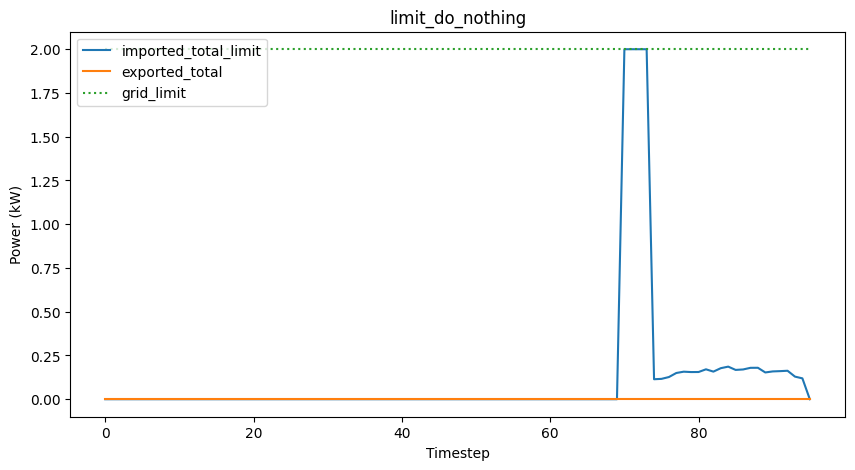

In [33]:
case_name = 'limit_do_nothing'
bat_discharge = eos_data['bat_discharge_none (kW)']
bat_charge = eos_data['bat_charge_none (kW)']
ev_charge = eos_data['ev_charge_none (kW)']
limits = eos_data['grid_limits_constant (kW)']

cost, imported, exported, imported_limit = calculate_cost(bat_discharge=bat_discharge,
                                                          bat_charge=bat_charge,
                                                          ev_charge=ev_charge,
                                                          limits=limits)

cases[case_name] = (cost, imported, exported, imported_limit, bat_discharge, bat_charge, ev_charge)

imported_limit.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
if case_name != 'no_limit':
    limits.name = 'grid_limit'
    limits.plot(figsize=(10,5), linestyle = 'dotted')
plt.legend(loc="upper left")
plt.title(case_name)
plt.xlabel('Timestep')
plt.ylabel('Power (kW)')

print('Cost:', cases[case_name][0])
print('Total Energy Needed:', (np.sum(imported_limit) -  np.sum(exported))*(1/4))
print('Energy Loss due to limits:', (np.sum(cases[case_name][1]) - np.sum(cases[case_name][3]))*(1/4))
plt.savefig('DSO_AnalysisCases_{}.pdf'.format(case_name), dpi=600)

### 3. Shift import after limit

This represents a reactive response scheme to a grid-imposed limit. The building realizes in real time that its load is being curtailed and thus shifts any excess to the next available time slot.

Cost: 2.9343181366671622
Total Energy Needed: 11.304057492917034
Energy Loss due to limits: 1.7763568394002505e-15


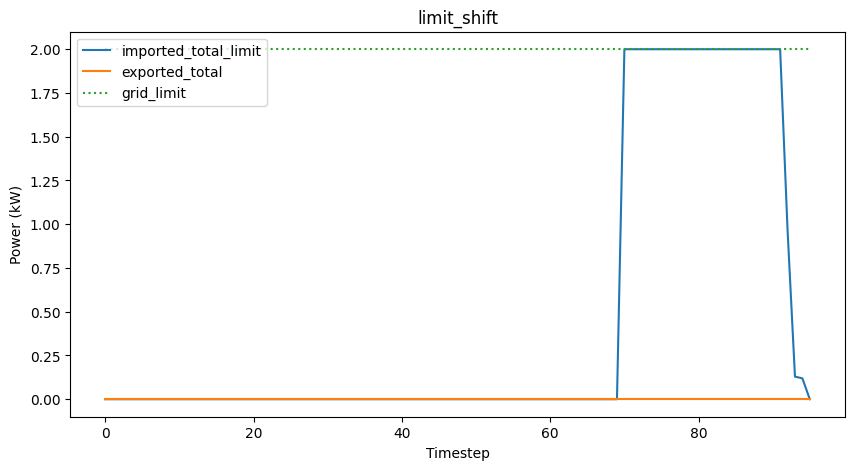

In [34]:
case_name = 'limit_shift'
bat_discharge = eos_data['bat_discharge_none (kW)']
bat_charge = eos_data['bat_charge_none (kW)']
ev_charge = eos_data['ev_charge_none (kW)']
limits = eos_data['grid_limits_constant (kW)']

cost, imported, exported, imported_limit = calculate_cost(bat_discharge=bat_discharge,
                                                          bat_charge=bat_charge,
                                                          ev_charge=ev_charge,
                                                          limits=limits,
                                                          fix=True)

cases[case_name] = (cost, imported, exported, imported_limit, bat_discharge, bat_charge, ev_charge)

imported_limit.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
if case_name != 'no_limit':
    limits.name = 'grid_limit'
    limits.plot(figsize=(10,5), linestyle = 'dotted')
plt.legend(loc="upper left")
plt.title(case_name)
plt.xlabel('Timestep')
plt.ylabel('Power (kW)')

print('Cost:', cases[case_name][0])
print('Total Energy Needed:', (np.sum(imported_limit) -  np.sum(exported))*(1/4))
print('Energy Loss due to limits:', (np.sum(cases[case_name][1]) - np.sum(cases[case_name][3]))*(1/4))
plt.savefig('DSO_AnalysisCases_{}.pdf'.format(case_name), dpi=600)

### 4. Re-optimize after limit

This represents a proactive response. After receiving the day ahead schedule, the EnergyOS is able to inform the prosumers in its grid about possible limits and they are able to factor this into their optimizations. This is possible with EnergyOS but not with the current state of the art in EMS.

Cost: 2.913267288998469
Total Energy Needed: 11.338227735763132
Energy Loss due to limits: 7.105427357601002e-15


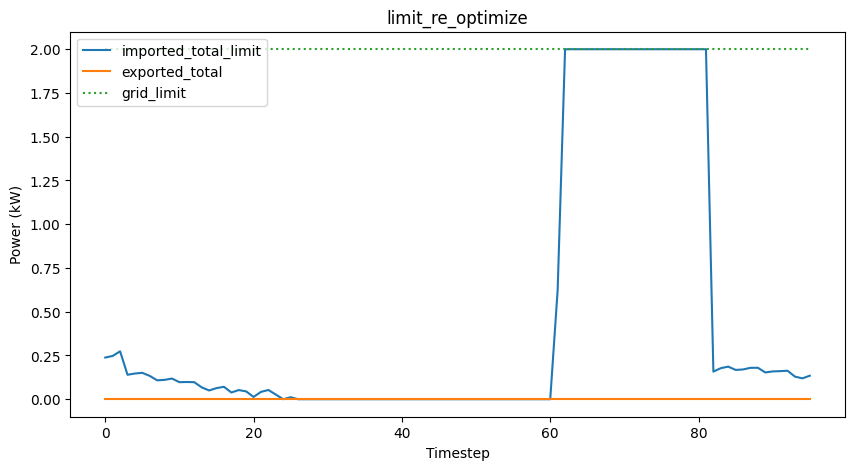

In [35]:
case_name = 'limit_re_optimize'
bat_discharge = eos_data['bat_discharge_constant (kW)']
bat_charge = eos_data['bat_discharge_none (kW)']
ev_charge = eos_data['ev_charge_constant (kW)']
limits = eos_data['grid_limits_constant (kW)']

cost, imported, exported, imported_limit = calculate_cost(bat_discharge=bat_discharge,
                                                          bat_charge=bat_charge,
                                                          ev_charge=ev_charge,
                                                          limits=limits)

cases[case_name] = (cost, imported, exported, imported_limit, bat_discharge, bat_charge, ev_charge)

imported_limit.plot(figsize=(10,5))
exported.plot(figsize=(10,5))
if case_name != 'no_limit':
    limits.name = 'grid_limit'
    limits.plot(figsize=(10,5), linestyle = 'dotted')
plt.legend(loc="upper left")
plt.title(case_name)
plt.xlabel('Timestep')
plt.ylabel('Power (kW)')

print('Cost:', cases[case_name][0])
print('Total Energy Needed:', (np.sum(imported_limit) -  np.sum(exported))*(1/4))
print('Energy Loss due to limits:', (np.sum(cases[case_name][1]) - np.sum(cases[case_name][3]))*(1/4))
plt.savefig('DSO_AnalysisCases_{}.pdf'.format(case_name), dpi=600)